## Preparation

In [1]:
import datetime, os
import pandas as pd
pd.set_option('display.max.colwidth', 100)
import numpy as np
import gensim
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine, cdist
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer

2022-12-07 18:24:49.162489: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

    def __init__(self, model_dir, path_prefix):
        self.path_prefix = path_prefix
        self.model_dir = model_dir
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        
    def on_train_end(self, model):
        model.save('{}/{}_epoch{}.model'.format(self.model_dir, self.path_prefix, self.epoch))

class EpochLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model3):
        loss = model3.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        if self.epoch % 50 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [3]:
# Smooth Inverse Frequency 
def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in xrange(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [4]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
contracts = pd.read_excel("../data/Contracts.xlsx")
# contracts = pd.read_excel("../data/Contracts_v2.xlsx")
outcomes = pd.DataFrame()
titles = pd.DataFrame()
for year in years:
    temp_outcome = pd.read_excel("../data/EXPORT"+str(year)+".xlsx").set_index('관리번호')
    temp_title = pd.read_excel("../data/"+str(year)+".xlsx").set_index('관리번호')
    outcomes = pd.concat([outcomes, temp_outcome], axis=0)
    titles = pd.concat([titles,temp_title], axis=0)

In [5]:
outcomes = pd.concat([outcomes, titles['제목(영어)']], axis=1)
outcomes = outcomes[['예외', '학년도', '성과물구분', '성과물구분명', '기준일', '제목', '제목(영어)', '상위소속명', '소속명', '교직원번호',
       '성명', '관련연구과제', '발송여부', '성과물확인', '교원업적', '자료제출방법', '연동여부(KRI)', '검증여부',
       '전송일시(KRI)', '총저자수']]

In [6]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
title_inv = inventions['제목(영어)'].drop_duplicates(keep='first')

In [7]:
outcomes_tech = outcomes[outcomes['성과물구분명']=='기술이전']
title_tech = []
index_tech = []
technologies = []
for i in tqdm(range(len(outcomes_tech))):
    if outcomes_tech.iloc[i]['제목'] in list(contracts['계약명칭']):
#         print(outcomes_tech.iloc[i]['성명'], contracts.iloc[list(contracts['계약명칭']).index(outcomes_tech.iloc[i]['제목'])]['책임발명자'])
        title_tech.append(outcomes_tech.iloc[i]['제목(영어)'])
        index_tech.append(outcomes_tech.iloc[i].name)
        index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]
        technologies.append(pd.concat([pd.Series(outcomes_tech.iloc[i].name).rename({0: "관리번호"}), pd.Series(outcomes_tech.iloc[i]['제목(영어)']).rename({0: "제목"}), contracts.loc[contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]]]))
title_tech = pd.Series(title_tech, index=index_tech).drop_duplicates(keep='first')
technologies = pd.concat(technologies, axis=1).T
technologies = technologies.drop(technologies['학과'][technologies['학과'].isna()].index)

100%|██████████| 631/631 [00:01<00:00, 357.08it/s]


In [119]:
title_tech.shape

(401,)

In [118]:
index_tech

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002031, 5000002034, 5000002036, 5000002037, 5000002042,
            5000002043, 5000002044, 5000002045, 5000002046, 5000002048],
           dtype='int64', length=401)

In [114]:
title_tech

5000000737    Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...
5000000739                                                                    12b low-power SAR-type ADC IP(3종)
5000000740          Improving image sensor design capabilities and transferring know-how to improve image quality
5000000741    Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...
5000000751                                  Know-how technology transfer for technology search system development
                                                             ...                                                 
5000002043        Transfer of know-how technology for PC Power Control Unit (SLM-12D) using biometric information
5000002044    Transfer of know-how for integrated electric vehicle charging service operation program that can...
5000002045    Four patent transfer technologies, including stereo denoising devices and st

In [21]:
name_idx = pd.Series(np.union1d(technologies['책임발명자'].unique(), inventions['성명'].unique()))
idx_name = pd.Series(name_idx.index, index=list(name_idx))
depart_idx = pd.Series(np.union1d(technologies['학과'].unique().astype('str')[technologies['학과'].unique().astype('str')!='nan'], inventions['소속명'].unique()))
idx_depart = pd.Series(depart_idx.index, index=list(depart_idx))
use_cols_inv = ['성과물구분명', '기준일', '제목(영어)', '소속명', 'depart_idx', '성명', 'name_idx']
use_cols_tech = ['관리번호', '기술구분', '계약일', '제목', '학과', 'depart_idx', '책임발명자', 'name_idx']

In [22]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])] # 기술이전된 invention은 후보에서 제외
inventions = pd.concat([inventions, pd.Series(map(lambda x: idx_name.loc[x], list(inventions['성명'])), index=inventions.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(inventions['소속명'])), index=inventions.index).rename("depart_idx")], axis=1)[use_cols_inv]
inventions = inventions.rename({'제목(영어)': 'title', '소속명': 'department', '성명': 'name', '기준일': 'date', '성과물구분명': 'type'}, axis=1)
inventions.index.name = 'inv_no'
title_inv = inventions['title'].drop_duplicates(keep='first')
inventions = inventions.loc[title_inv.index]

In [23]:
technologies = pd.concat([technologies, pd.Series(map(lambda x: idx_name.loc[x], list(technologies['책임발명자'])), index=technologies.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(technologies['학과'])), index=technologies.index).rename("depart_idx")], axis=1)[use_cols_tech]
technologies = technologies.rename({'관리번호': 'tech_no', '기술구분': 'type', '계약일': 'date', '제목': 'title', '학과': 'department', '책임발명자': 'name'}, axis=1)
technologies = technologies.set_index('tech_no')

In [36]:
inventions.apply(lambda x: x['name']+x['department'], axis=1).unique()

array(['이예경교육대학원', '김지환컴퓨터공학전공', '공경철기계공학전공', '신호창경영전문대학원', '최용순영상대학원',
       '신형두생명과학전공', '황선영전자공학전공', '김낙수기계공학전공', '윤광석전자공학전공', '김주영경영학전공',
       '김원정기계공학전공', '오영탁수학전공', '유양모전자공학전공', '김승욱컴퓨터공학전공', '정진호전자공학전공',
       '김현철화공생명공학전공', '송민섭경영학전공', '박래홍전자공학전공', '최우영전자공학전공',
       'Barrie Michael Jonathan Mathew영미어문전공', '허남건기계공학전공', '손기헌기계공학전공',
       '김대중기계공학전공', '김동철기계공학전공', '이형일기계공학전공', '김충현커뮤니케이션학전공',
       'Loh, Kah Seng동아연구소', '주하연경제학전공', '안태현경제학전공', '김대산수학전공',
       '이갑열생명과학전공', '김종락수학전공', '심종혁서강대학교', '최수정법학전문대학원', '이정국생명과학전공',
       'Gueron, Yves Simon Bernard경제학전공', '김재영종교학전공', '임채호물리학전공',
       '한기백교육대학원', '박운상컴퓨터공학전공', 'Unger, Michael Anthony영상대학원',
       '장진호바이오융합기술연구소', '이준겸경영학전공', '이정민경제학과', '이범훈물리학전공', '신관우화학전공',
       '주봉건생명과학전공', '오한빈화학전공', '이욱연중국문화전공', '민재형경영학전공', '이윤수경제학전공',
       '홍대식법학전문대학원', '김성룡생명과학전공', '김광수전자공학전공', '허윤국제대학원', '정문열영상대학원',
       '이영주경영학전공', '정순영수학전공', '이보아아트&테크놀로지전공', '황화상국어국문학전공', '김범수경영전문대학원',
       '구기갑화공생명공학전공', '김연신유럽문화전공', '강선경신학대학원

In [18]:
technologies.head()

,type,date,title,department,depart_idx,name,name_idx
tech_no,,,,,,,
5000000737,Know-How,2015-01-30,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,전자공학전공,53,범진욱,246
5000000739,Know-How,2015-03-01,12b low-power SAR-type ADC IP(3종),전자공학전공,53,이승훈,394
5000000740,Know-How,2015-03-27,Improving image sensor design capabilities and transferring know-how to improve image quality,전자공학전공,53,최희철,591
5000000741,Know-How,2015-08-04,"Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...",기계공학전공,14,손기헌,268
5000000751,Know-How,2015-08-03,Know-how technology transfer for technology search system development,컴퓨터공학전공,60,박운상,224


In [80]:
index_inv = title_inv.index
index_tech = title_tech.index
print("#research: {}, #technology: {}".format(len(inventions), len(technologies)))

#research: 16517, #technology: 565


In [45]:
text = "&ADSF-"
re.findall('[a-zA-Z0-9\-\__]+', text)

['ADSF-']

In [44]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ['A', 'The', '-']

def no_nums(text):
    return ' '.join(filter(lambda word:word.replace('.','').replace(',','').isdigit()==False, text.split()))

def extract_word(text):
#     text = no_nums(text)
#     word_list = re.findall('[a-zA-Z0-9\-\__]+', text)
    word_list = re.findall('[a-zA-Z0-9]+', text)
    word_list = [word for word in word_list if word not in stop_words]
    word_list = [word for word in word_list if not word.isdigit()]
    return word_list

def remove_rare_words(word_list):
    out = [word for word in word_list if word not in rare_words]
    if out == []:
        return ['_NOWORDS_']
    else:
        return out
    
def word_padding(word_list):
    if len(word_list)<2:
        return word_list*2
    else:
        return word_list

# def remove_rare_words(title_list, rare_words):
#     output, noword_index = [], []
#     for i in tqdm(range(len(title_list))):
#         word_list = title_list[i]
#         temp = [word for word in word_list if word not in rare_words]
#         if temp == []:
#             noword_index.append(i)
#         else:
#             output.append(temp)
#     return output

def calc_vec(model, title_list, method='avg', list_total=None, alpha=1e-3):
    if method=='sbert':
        return pd.Series(list(model.encode(title_list.values, convert_to_tensor=False)), index=title_list.index)
#         return list(model.encode(title_list.values, convert_to_tensor=False))
    else:
        out_vec = []
        if method in ['sif', 'sif_weight']:
            words_unq, words_weights = np.unique(list_total, return_counts=True)
            if method=='sif_weight':
                words_weights = words_weights / len(list_total)
                words_weights = alpha / (alpha + words_weights)
            else:
                words_weights = words_weights / len(list_total)
        for word_list in title_list:
            if method=='avg':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sum':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.sum(sentence_vec, axis=0))
            elif method=='sif':
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = np.array([model.wv[word] for word in word_list])
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sif_weight':
                ww_s = np.array([words_weights[np.where(words_unq==word)[0][0]] for word in word_list])
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = ww_s.dot(wv_s) / np.count_nonzero(ww_s)
                out_vec.append(sentence_vec)
        if method in ['sif', 'sif_weight']:
            out_vec = np.array(out_vec)
            out_vec = list(remove_pc(out_vec, 1))
        return pd.Series(out_vec, index=title_list.index)

def get_loc(df, index):
    return df.index[index]

def get_iloc(df, index):
    return list(df.index).index(index)

def calc_rank(vec_tech, vec_inv, topk=5):
    index_inv = vec_inv.index
    index_tech = vec_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    top_candidates = {}
    for id_target in vec_tech.index:
        top_candidates[id_target] = {}
        iloc_target = get_iloc(vec_tech, id_target)
        top_invention = inventions.loc[index_inv[np.argsort(dist_list[iloc_target])]]['name'].drop_duplicates(keep='first')[:topk].index
        top_candidates[id_target]['title'] = inventions.loc[top_invention]['title']
        top_candidates[id_target]['inventor'] = inventions.loc[top_invention]['name']
        top_candidates[id_target]['department'] = inventions.loc[top_invention]['department']
        top_candidates[id_target]['inventor_idx'] = inventions.loc[top_invention]['name_idx']
        top_candidates[id_target]['department_idx'] = inventions.loc[top_invention]['depart_idx']
        top_candidates[id_target]['distance'] = pd.Series(dist_list[iloc_target], index=vec_inv.index).loc[top_invention]
    return top_candidates

In [109]:
vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)

In [123]:
dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')

In [142]:
np.argsort(dist_list[10])

array([ 5876, 14804,  6904, ..., 10653, 15005, 13867])

In [144]:
dist_list[10][10]

0.5469692355611339

In [124]:
dist_list.shape

(401, 16497)

In [133]:
inventions.loc[vec_inv.index[np.argsort(dist_list[10])]]

,type,date,title,department,depart_idx,name,name_idx
inv_no,,,,,,,
4000003206,특허,2016-08-09,How to search for patents subject to technology transfer in related patents,기계공학전공,14,김동철,86
30873,논문,2020-08-01,Navigating a product landscape for technology opportunity analysis: A word2vec approach using an...,기술경영전문대학원,15,안준모,300
27613,논문,2017-08-31,The impact of technology convergence on corporate performance: focusing on automotive companies ...,기술경영전문대학원,15,문성욱,198
6000016312,교외연구비,2017-01-06,Flow analysis and Triple - Passage Heat Exehangers for technology transfer technology development.,기계공학전공,14,허남건,604
26691,논문,2018-02-28,The framework for factors affecting technology transfer for suppliers and buyers of technology i...,기술경영전문대학원,15,김완기,119
...,...,...,...,...,...,...,...
2000032767,학술회의발표,2021-02-05,Understanding of MERGE,국어국문학전공,10,이정훈,422
2000026592,학술회의발표,2015-04-04,Danger and Safety,법학전문대학원,25,이호중,455
2000030075,학술회의발표,2018-10-27,Yeom Sang-seop and Lucheen,국어국문학전공,10,김경수,65


In [139]:
technologies.loc[vec_tech.index[10]]

type                                                            Know-How
date                                                 2015-12-11 00:00:00
title         Know-How technology transfer for Lakota Cheese development
department                                                       경영전문대학원
depart_idx                                                             2
name                                                                 김용진
name_idx                                                             121
Name: 5000000804, dtype: object

In [160]:
vec_tech.index

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002031, 5000002034, 5000002036, 5000002037, 5000002042,
            5000002043, 5000002044, 5000002045, 5000002046, 5000002048],
           dtype='int64', length=401)

In [161]:
technologies.index

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002107, 5000002130, 5000002132, 5000002141, 5000002142,
            5000002143, 5000002144, 5000002146, 5000002148, 5000002151],
           dtype='int64', name='tech_no', length=565)

In [159]:
technologies.loc[vec_tech.index]

KeyError: '[5000001490, 5000001543, 5000001083, 5000001224, 5000001503] not in index'

In [158]:
list_tech

5000000737    [Know, develop, high, speed, signal, interface, circuits, future, intelligent, healthcare, platf...
5000000739                                                                  [12b, low, power, SAR, type, ADC, IP]
5000000740          [Improving, image, sensor, design, capabilities, transferring, know, improve, image, quality]
5000000741    [Transfer, know, fluid, Phase, Change, Heat, Fluid, Analysis, enhance, performance, phase, chang...
5000000751                                  [Know, technology, transfer, technology, search, system, development]
                                                             ...                                                 
5000002043                  [Transfer, know, technology, PC, Power, Control, Unit, using, biometric, information]
5000002044    [Transfer, know, integrated, electric, vehicle, charging, service, operation, program, check, el...
5000002045    [Four, patent, transfer, technologies, including, stereo, denoising, devic

In [146]:
title_tech[vec_tech.index[10]]

'Know-How technology transfer for Lakota Cheese development'

In [156]:
'Know-How technology transfer for Lakota Cheese development' in title_inv.values

False

In [138]:
vec_tech.index[10]

5000000804

In [129]:
inventions.loc[vec_inv.index[np.argsort(dist_list[10])]]['name'].drop_duplicates(keep='first')[:5].index

Int64Index([4000003206, 30873, 27613, 6000016312, 26691], dtype='int64', name='inv_no')

In [121]:
list_inv = pd.Series(list(map(extract_word, title_inv)), index=index_inv)
list_tech = pd.Series(list(map(extract_word, title_tech)), index=index_tech)
list_total = sum((list(list_tech)+list(list_inv)), [])

words_unq, words_counts = np.unique(list_total, return_counts=True)
rare_words = words_unq[words_counts==1]

list_inv = list_inv.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_inv.values) if '_NOWORDS_' not in l]
list_inv = list_inv.iloc[temp_index]
list_inv = list_inv.map(word_padding)

list_tech = list_tech.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_tech.values) if '_NOWORDS_' not in l]
list_tech = list_tech.iloc[temp_index]
list_tech = list_tech.map(word_padding)

list_total = sum((list(list_tech)+list(list_inv)), [])

sentences_to_train = list(pd.concat([list_inv, list_tech]))

## Draft

In [50]:
MODEL_DIR="../models"

model_type_to_load = input("Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): ")
if model_type_to_load in ['1', 'load_pretrained']:
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['2', 'load_transfer']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_transfer_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)    
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_transfer_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_transfer_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['3', 'load_new']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_new_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_new_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_additional_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['4', 'train_transfer']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Before building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    print(f"== BUILD vocab START at {datetime.datetime.now()}")
    ft_model.build_vocab(sentences_to_train, update=True, keep_raw_vocab=True)
    print(f"== BUILD vocab END at {datetime.datetime.now()}")
    print("After building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_additional')
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train, 
                   total_examples=len(sentences_to_train),
                   epochs=n_epochs,
                   compute_loss=True,
                   callbacks=[epoch_saver, epoch_logger]
                  )
elif model_type_to_load in ['5', 'train_new']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    vector_size = input("Vector size: ")
    vector_size = int(vector_size)
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size, window=7, workers=4, negative=7)
    ft_model.build_vocab(sentences_to_train)
    print("Vocab size",len(ft_model.wv.key_to_index))
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False,
           callbacks=[epoch_saver, epoch_logger])

Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): 3
Available number of epochs: ['1000', '10000', '10000-Copy1']
#epochs: 10000
== LOAD fasttext model START at 2022-12-07 18:34:44.444132
== LOAD fasttext model END at 2022-12-07 18:34:49.892425
Tech_licensing_additional_epoch10000 is loaded
Vocab size 12573


In [51]:
ft_model.vector_size

64

## Revision

In [36]:
MODEL_DIR="../models"

In [47]:
params = {}
params['n_epochs'] = candidates['n_epochs'][0]
params['vector_size'] = candidates['vector_size'][0]
params['window_size'] = candidates['window_size'][0]

In [275]:
tech_outcomes['index'].apply(lambda x: inventions.loc[inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['name'].drop_duplicates(keep='first')[:topk].index]['name'].values)

0      [범진욱, 김영재, 손원민, 박수용, 정문열]
1      [범진욱, 이승훈, 김주호, 최우영, 안길초]
2      [김영재, 범진욱, 강석주, 서용덕, 정진호]
3      [손기헌, 허남건, 김동철, 김원정, 이광순]
4      [강석주, 구명완, 김현철, 박운상, 이광순]
                 ...            
396    [성원진, 이행선, 김지환, 정진호, 이승훈]
397    [김홍석, 장주욱, 이승엽, 강석주, 박수용]
398    [성원진, 박형민, 임인성, 양지훈, 이성준]
399    [박수용, 강성원, 정문열, 구명완, 김현철]
400    [박형민, 소재우, 정성원, 서용덕, 강석주]
Name: index, Length: 401, dtype: object

In [409]:
def run(params):
    n_epochs = params['n_epochs']
    vector_size = params['vector_size']
    window_size = params['window_size']
    n_neg_samples = params['n_neg_samples']
    print(f"[n_epochs: {n_epochs}, vector_size: {vector_size}, window_size: {window_size}, n_neg_samples: {n_neg_samples}]")
    curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])
    
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size, window=window_size, workers=20, negative=n_neg_samples)
#     print(ft_model.vector_size)
    ft_model.build_vocab(sentences_to_train)
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False)
#            callbacks=[epoch_saver, epoch_logger])
    print("model training done")
    
    vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)
    
    index_inv = vec_inv.index
    index_tech = vec_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    
    candidates = {}
    candidates['inventor'] = tech_outcomes['index'].apply(lambda x: inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['name'].drop_duplicates(keep='first').values)
    candidates['inventor'].index = vec_tech.index
    candidates['department'] = tech_outcomes['index'].apply(lambda x: inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['department'].drop_duplicates(keep='first').values)
    candidates['department'].index = vec_tech.index
    
    # Matching ratio
    matching_rate = {'i_'+curr_params: [], 'd_'+curr_params: []}
    for k in range(1,11):
        cnt_matched = {}
        cnt_matched['inventor'] = tech_outcomes['index'].apply(lambda x: 1 if tech_outcomes[tech_outcomes['index']==x]['성명'].item() in candidates['inventor'].loc[x][:k] else 0)
        cnt_matched['department'] = tech_outcomes['index'].apply(lambda x: 1 if tech_outcomes[tech_outcomes['index']==x]['소속명'].item() in candidates['department'].loc[x][:k] else 0)
        matching_rate['i_'+curr_params].append(np.round(cnt_matched['inventor'].sum() / len(cnt_matched['inventor']), 4))
        matching_rate['d_'+curr_params].append(np.round(cnt_matched['department'].sum() / len(cnt_matched['department']), 4))
        
    return matching_rate

In [412]:
# candidates = {
#     'n_epochs': [100],
#     'vector_size': [300],
#     'window_size': [7],
#     'n_neg_samples': [5]
# }

Sensitivitiy analysis on n_epochs, window_size, n_neg_samples

In [416]:
candidates = {
    'n_epochs': [500, 2500, 5000, 10000],
    'vector_size': [300],
    'window_size': [3, 5, 7, 10],
    'n_neg_samples': [3, 5, 7, 10]
}

In [ ]:
df_out = {}
for n_epochs in candidates['n_epochs']:
    for vector_size in candidates['vector_size']:
        for window_size in candidates['window_size']:
            for n_neg_samples in candidates['n_neg_samples']:
                stime = time.time()
                params['n_epochs'] = n_epochs
                params['vector_size'] = vector_size
                params['window_size'] = window_size
                params['n_neg_samples'] = n_neg_samples
                curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])

                matching_rate = run(params=params)

                df_out[curr_params] = pd.DataFrame.from_dict(matching_rate).rename_axis(curr_params)
                etime = time.time()
                print(f"{np.round(etime-stime, 4)} sec elapsed\n")

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 3]
model training done
218.6832 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 5]
model training done
240.7461 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 7]
model training done
264.9532 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 10]
model training done
266.2814 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 3]
model training done
266.0391 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 5]
model training done
268.2892 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 7]
model training done
271.2715 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 10]
model training done
316.1434 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 7, n_neg_samples: 3]
model training done
266.5573 sec elapsed

[n_epoch

In [435]:
df_out

{'n500v300w3neg3':                 i_n500v300w3neg3  d_n500v300w3neg3
 n500v300w3neg3                                    
 0                         0.3691            0.5486
 1                         0.4389            0.6783
 2                         0.4763            0.7431
 3                         0.5112            0.7880
 4                         0.5262            0.8254
 5                         0.5362            0.8504
 6                         0.5461            0.8703
 7                         0.5711            0.8853
 8                         0.5835            0.9052
 9                         0.5935            0.9127,
 'n500v300w3neg5':                 i_n500v300w3neg5  d_n500v300w3neg5
 n500v300w3neg5                                    
 0                         0.3641            0.5536
 1                         0.4314            0.6858
 2                         0.4813            0.7357
 3                         0.5087            0.7731
 4                         

In [436]:
df_total_temp = pd.concat([df for df in df_out.values()], axis=1).T

In [437]:
df_total_temp

,0,1,2,3,4,5,6,7,8,9
i_n500v300w3neg3,0.3691,0.4389,0.4763,0.5112,0.5262,0.5362,0.5461,0.5711,0.5835,0.5935
d_n500v300w3neg3,0.5486,0.6783,0.7431,0.7880,0.8254,0.8504,0.8703,0.8853,0.9052,0.9127
i_n500v300w3neg5,0.3641,0.4314,0.4813,0.5087,0.5187,0.5312,0.5511,0.5786,0.5935,0.6035
d_n500v300w3neg5,0.5536,0.6858,0.7357,0.7731,0.8180,0.8529,0.8678,0.8903,0.9027,0.9102
i_n500v300w3neg7,0.3791,0.4364,0.4863,0.5137,0.5362,0.5461,0.5611,0.5761,0.5860,0.5985
...,...,...,...,...,...,...,...,...,...,...
d_n10000v300w10neg5,0.5686,0.6883,0.7406,0.7905,0.8329,0.8628,0.8878,0.8903,0.9027,0.9077
i_n10000v300w10neg7,0.3890,0.4589,0.5062,0.5337,0.5536,0.5661,0.5761,0.5935,0.6110,0.6160
d_n10000v300w10neg7,0.5835,0.6983,0.7481,0.7980,0.8254,0.8429,0.8778,0.8878,0.8953,0.9027
i_n10000v300w10neg10,0.3915,0.4539,0.5062,0.5287,0.5436,0.5611,0.5786,0.5885,0.6010,0.6085


In [505]:
print("AS")

AS


In [442]:
df_total = pd.concat([df for df in df_out.values()], axis=1).T

In [441]:
df_total

,i_n500v300w3neg3,d_n500v300w3neg3,i_n500v300w3neg5,d_n500v300w3neg5,i_n500v300w3neg7,d_n500v300w3neg7,i_n500v300w3neg10,d_n500v300w3neg10,i_n500v300w5neg3,d_n500v300w5neg3,...,i_n10000v300w7neg10,d_n10000v300w7neg10,i_n10000v300w10neg3,d_n10000v300w10neg3,i_n10000v300w10neg5,d_n10000v300w10neg5,i_n10000v300w10neg7,d_n10000v300w10neg7,i_n10000v300w10neg10,d_n10000v300w10neg10
0,0.3691,0.5486,0.3641,0.5536,0.3791,0.5511,0.3666,0.5411,0.3766,0.5561,...,0.3766,0.5461,0.3865,0.5661,0.3840,0.5686,0.3890,0.5835,0.3915,0.5761
1,0.4389,0.6783,0.4314,0.6858,0.4364,0.6833,0.4439,0.6733,0.4414,0.6858,...,0.4564,0.6908,0.4539,0.6908,0.4514,0.6883,0.4589,0.6983,0.4539,0.6833
2,0.4763,0.7431,0.4813,0.7357,0.4863,0.7481,0.4913,0.7332,0.4963,0.7431,...,0.5062,0.7506,0.4963,0.7431,0.5062,0.7406,0.5062,0.7481,0.5062,0.7606
3,0.5112,0.7880,0.5087,0.7731,0.5137,0.8005,0.5237,0.8005,0.5237,0.7980,...,0.5362,0.7880,0.5387,0.7955,0.5312,0.7905,0.5337,0.7980,0.5287,0.7930
4,0.5262,0.8254,0.5187,0.8180,0.5362,0.8329,0.5337,0.8254,0.5337,0.8279,...,0.5536,0.8204,0.5561,0.8229,0.5511,0.8329,0.5536,0.8254,0.5436,0.8254
5,0.5362,0.8504,0.5312,0.8529,0.5461,0.8504,0.5511,0.8554,0.5511,0.8529,...,0.5736,0.8479,0.5686,0.8579,0.5661,0.8628,0.5661,0.8429,0.5611,0.8529
6,0.5461,0.8703,0.5511,0.8678,0.5611,0.8728,0.5611,0.8778,0.5686,0.8703,...,0.5810,0.8753,0.5810,0.8728,0.5860,0.8878,0.5761,0.8778,0.5786,0.8703
7,0.5711,0.8853,0.5786,0.8903,0.5761,0.8878,0.5711,0.8878,0.5810,0.8903,...,0.6010,0.8928,0.5935,0.8928,0.5960,0.8903,0.5935,0.8878,0.5885,0.8853
8,0.5835,0.9052,0.5935,0.9027,0.5860,0.9002,0.5810,0.8978,0.5885,0.9002,...,0.6085,0.9102,0.6135,0.9027,0.6110,0.9027,0.6110,0.8953,0.6010,0.9002
9,0.5935,0.9127,0.6035,0.9102,0.5985,0.9127,0.5860,0.9027,0.6110,0.9002,...,0.6135,0.9127,0.6234,0.9077,0.6185,0.9077,0.6160,0.9027,0.6085,0.9127


In [443]:
df_total.to_csv("../results/revision_out.csv")

In [497]:
df_total = pd.read_csv("../results/revision_out_v1.csv").set_index("Unnamed: 0")
df_total_i = df_total.loc[pd.Index([x for x in df_total.index if "i" in x])]

n_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('n')[1].split('v')[0])
n_series.name = 'n'
v_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('v')[1].split('w')[0])
v_series.name = 'v'
w_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('w')[1].split('neg')[0])
w_series.name = 'w'

df_total_i_out = pd.concat([n_series, v_series, w_series, df_total_i.reset_index()], axis=1).set_index('index')
df_total_i_out.to_csv("../results/revision_out_i_v1.csv")

In [498]:
df_total_i_out

,n,v,w,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,,,,
i_n500v100w3,500,100,3,0.3491,0.4214,0.4589,0.4788,0.5037,0.5337,0.5536,0.5761,0.5885,0.6010
i_n500v100w5,500,100,5,0.3865,0.4613,0.5112,0.5362,0.5661,0.5860,0.5985,0.6135,0.6209,0.6284
i_n500v100w7,500,100,7,0.3865,0.4514,0.4963,0.5312,0.5461,0.5810,0.6010,0.6085,0.6160,0.6259
i_n500v100w10,500,100,10,0.3766,0.4564,0.5037,0.5312,0.5661,0.5736,0.5960,0.6010,0.6060,0.6110
i_n500v200w3,500,200,3,0.3641,0.4389,0.4763,0.5012,0.5162,0.5362,0.5511,0.5736,0.5786,0.5885
i_n500v200w5,500,200,5,0.3766,0.4489,0.4913,0.5237,0.5486,0.5661,0.5736,0.5885,0.5985,0.6085
i_n500v200w7,500,200,7,0.3865,0.4489,0.4938,0.5212,0.5411,0.5586,0.5736,0.5910,0.6060,0.6209
i_n500v200w10,500,200,10,0.3940,0.4564,0.4913,0.5162,0.5461,0.5561,0.5661,0.5835,0.5960,0.6110
i_n500v300w3,500,300,3,0.3716,0.4414,0.4838,0.4988,0.5212,0.5411,0.5586,0.5761,0.5935,0.6035


In [513]:
df_total = pd.read_csv("../results/revision_out_v2.csv").set_index("Unnamed: 0")
df_total_i = df_total.loc[pd.Index([x for x in df_total.index if "i" in x])]

n_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('n')[1].split('v')[0])
n_series.name = 'n'
v_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('v')[1].split('w')[0])
v_series.name = 'v'
w_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('w')[1].split('neg')[0])
w_series.name = 'w'
neg_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('neg')[1])
neg_series.name = 'neg'

df_total_i_out = pd.concat([n_series, v_series, w_series, neg_series, df_total_i.reset_index()], axis=1).set_index('index')
df_total_i_out.to_csv("../results/revision_out_i_v2.csv")

In [514]:
matching_rate df_total_i_out[]

,n,v,w,neg,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,,,,,
i_n500v300w3neg3,500,300,3,3,0.3691,0.4389,0.4763,0.5112,0.5262,0.5362,0.5461,0.5711,0.5835,0.5935
i_n500v300w3neg5,500,300,3,5,0.3641,0.4314,0.4813,0.5087,0.5187,0.5312,0.5511,0.5786,0.5935,0.6035
i_n500v300w3neg7,500,300,3,7,0.3791,0.4364,0.4863,0.5137,0.5362,0.5461,0.5611,0.5761,0.5860,0.5985
i_n500v300w3neg10,500,300,3,10,0.3666,0.4439,0.4913,0.5237,0.5337,0.5511,0.5611,0.5711,0.5810,0.5860
i_n500v300w5neg3,500,300,5,3,0.3766,0.4414,0.4963,0.5237,0.5337,0.5511,0.5686,0.5810,0.5885,0.6110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i_n10000v300w7neg10,10000,300,7,10,0.3766,0.4564,0.5062,0.5362,0.5536,0.5736,0.5810,0.6010,0.6085,0.6135
i_n10000v300w10neg3,10000,300,10,3,0.3865,0.4539,0.4963,0.5387,0.5561,0.5686,0.5810,0.5935,0.6135,0.6234
i_n10000v300w10neg5,10000,300,10,5,0.3840,0.4514,0.5062,0.5312,0.5511,0.5661,0.5860,0.5960,0.6110,0.6185


In [532]:

df_total_i_out.loc['i_n2500v300w10neg5'][np.arange(10).astype(str)]

0    0.3965
1    0.4589
2    0.5012
3    0.5362
4    0.5586
5    0.5736
6    0.5835
7    0.6035
8    0.6135
9     0.616
Name: i_n2500v300w10neg5, dtype: object

In [540]:
df_total.loc['d_n2500v300w10neg5']

0    0.5786
1    0.6933
2    0.7506
3    0.7930
4    0.8229
5    0.8603
6    0.8778
7    0.8903
8    0.9102
9    0.9152
Name: d_n2500v300w10neg5, dtype: float64

In [541]:
matching_rate['inventor'] = df_total_i_out.loc['i_n2500v300w10neg5'][np.arange(10).astype(str)]
matching_rate['department'] = df_total.loc['d_n2500v300w10neg5'][np.arange(10).astype(str)]

In [548]:
pd.DataFrame(matching_rate['department'])

,d_n2500v300w10neg5
0,0.5786
1,0.6933
2,0.7506
3,0.7930
4,0.8229
5,0.8603
6,0.8778
7,0.8903
8,0.9102
9,0.9152


/tmp/ipykernel_24740/1278411735.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
/tmp/ipykernel_24740/1278411735.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)


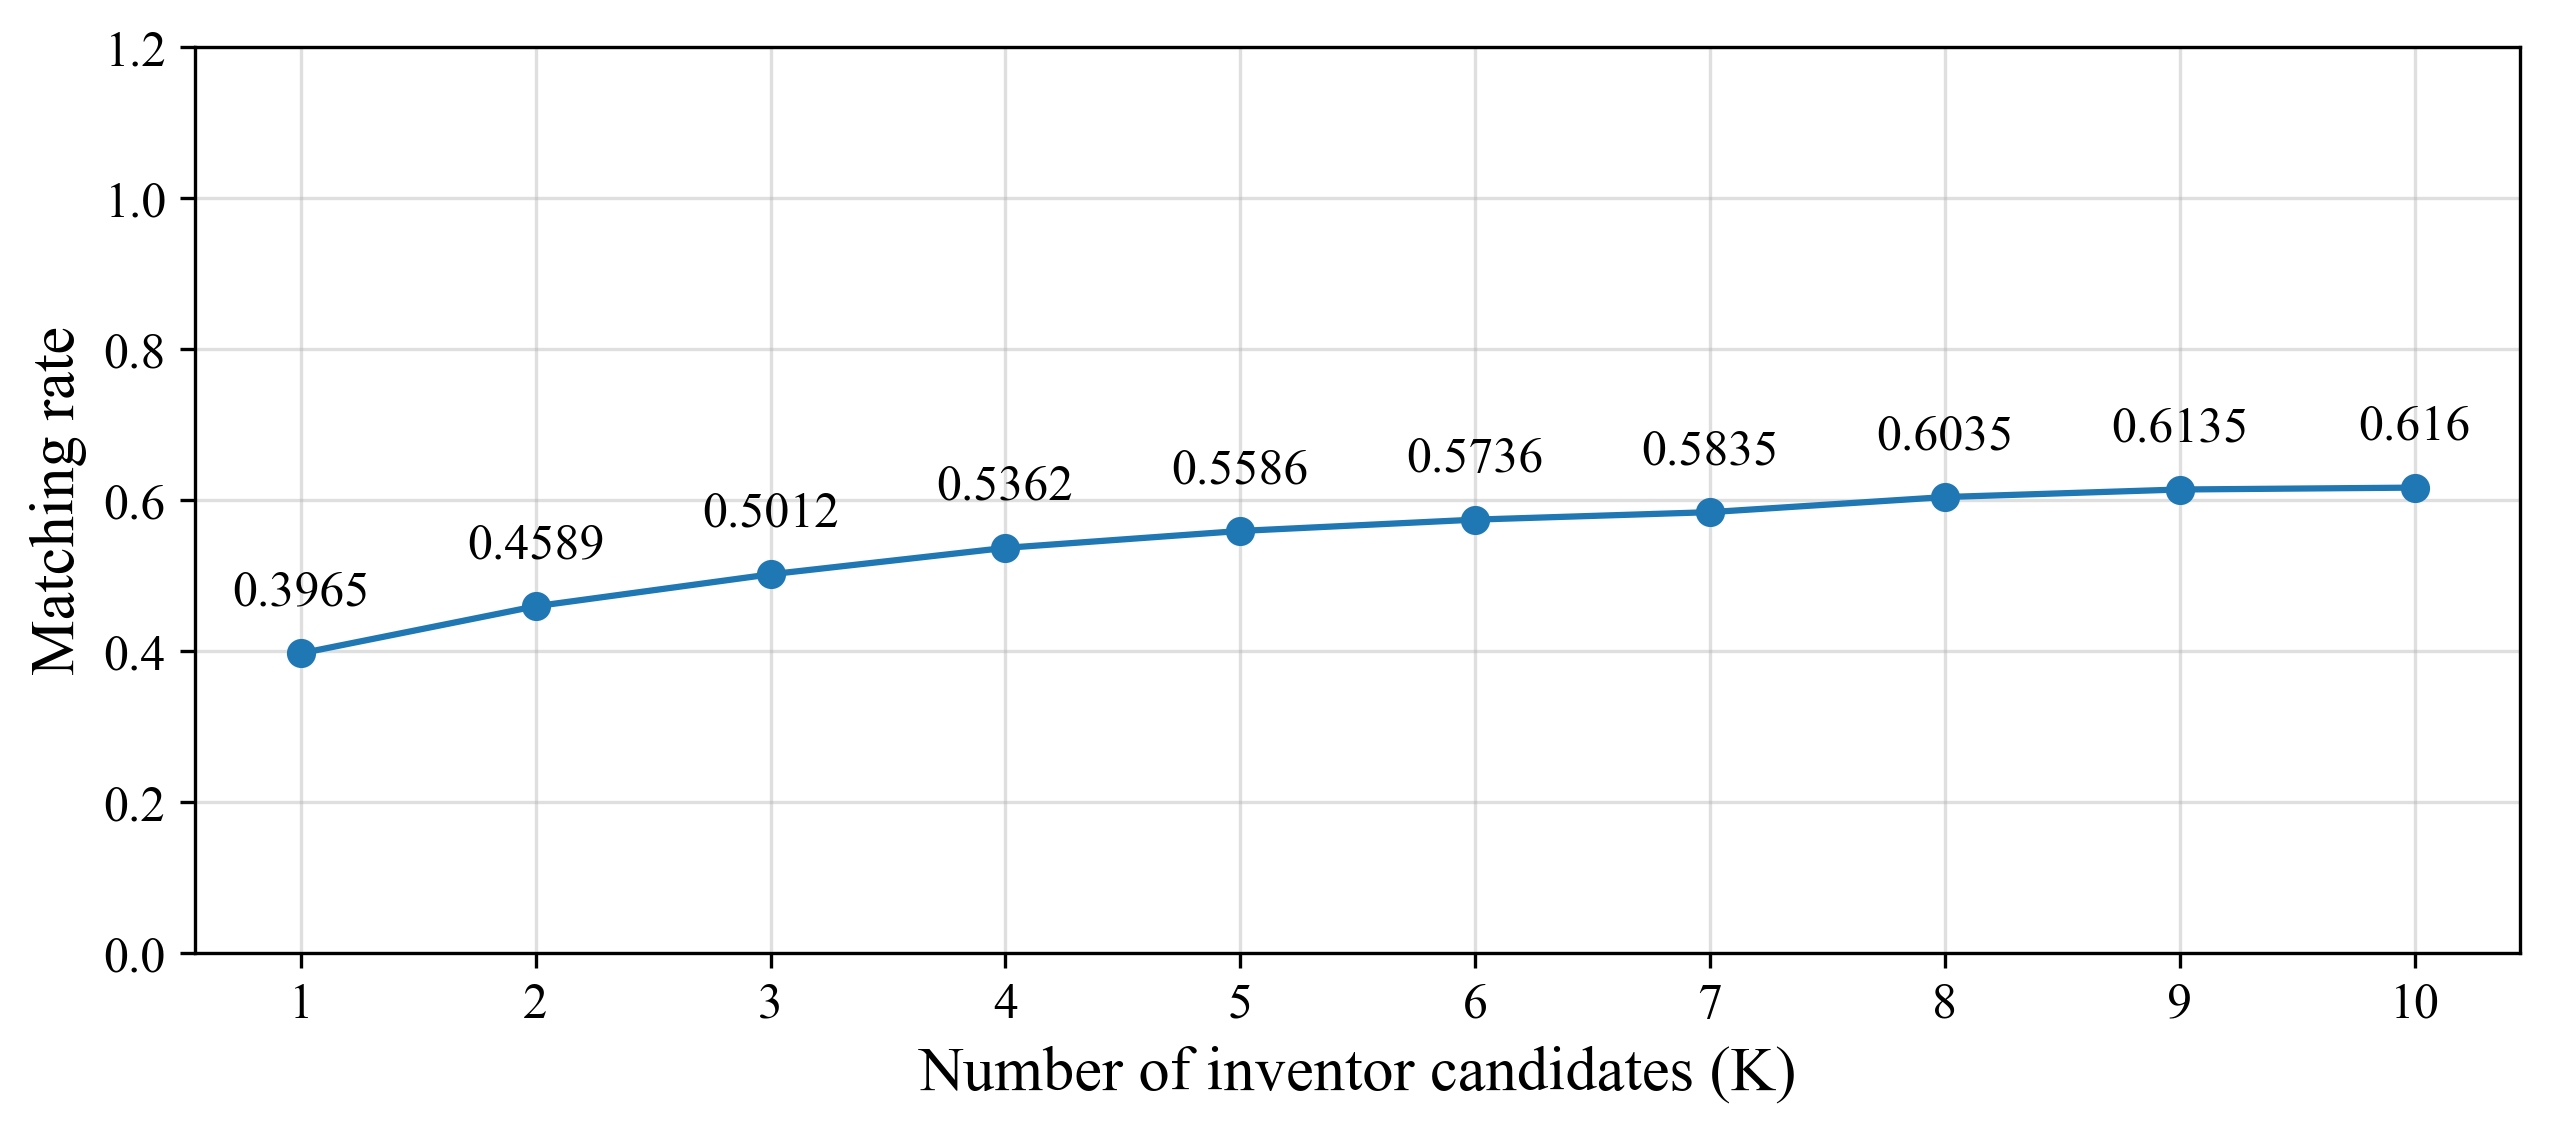

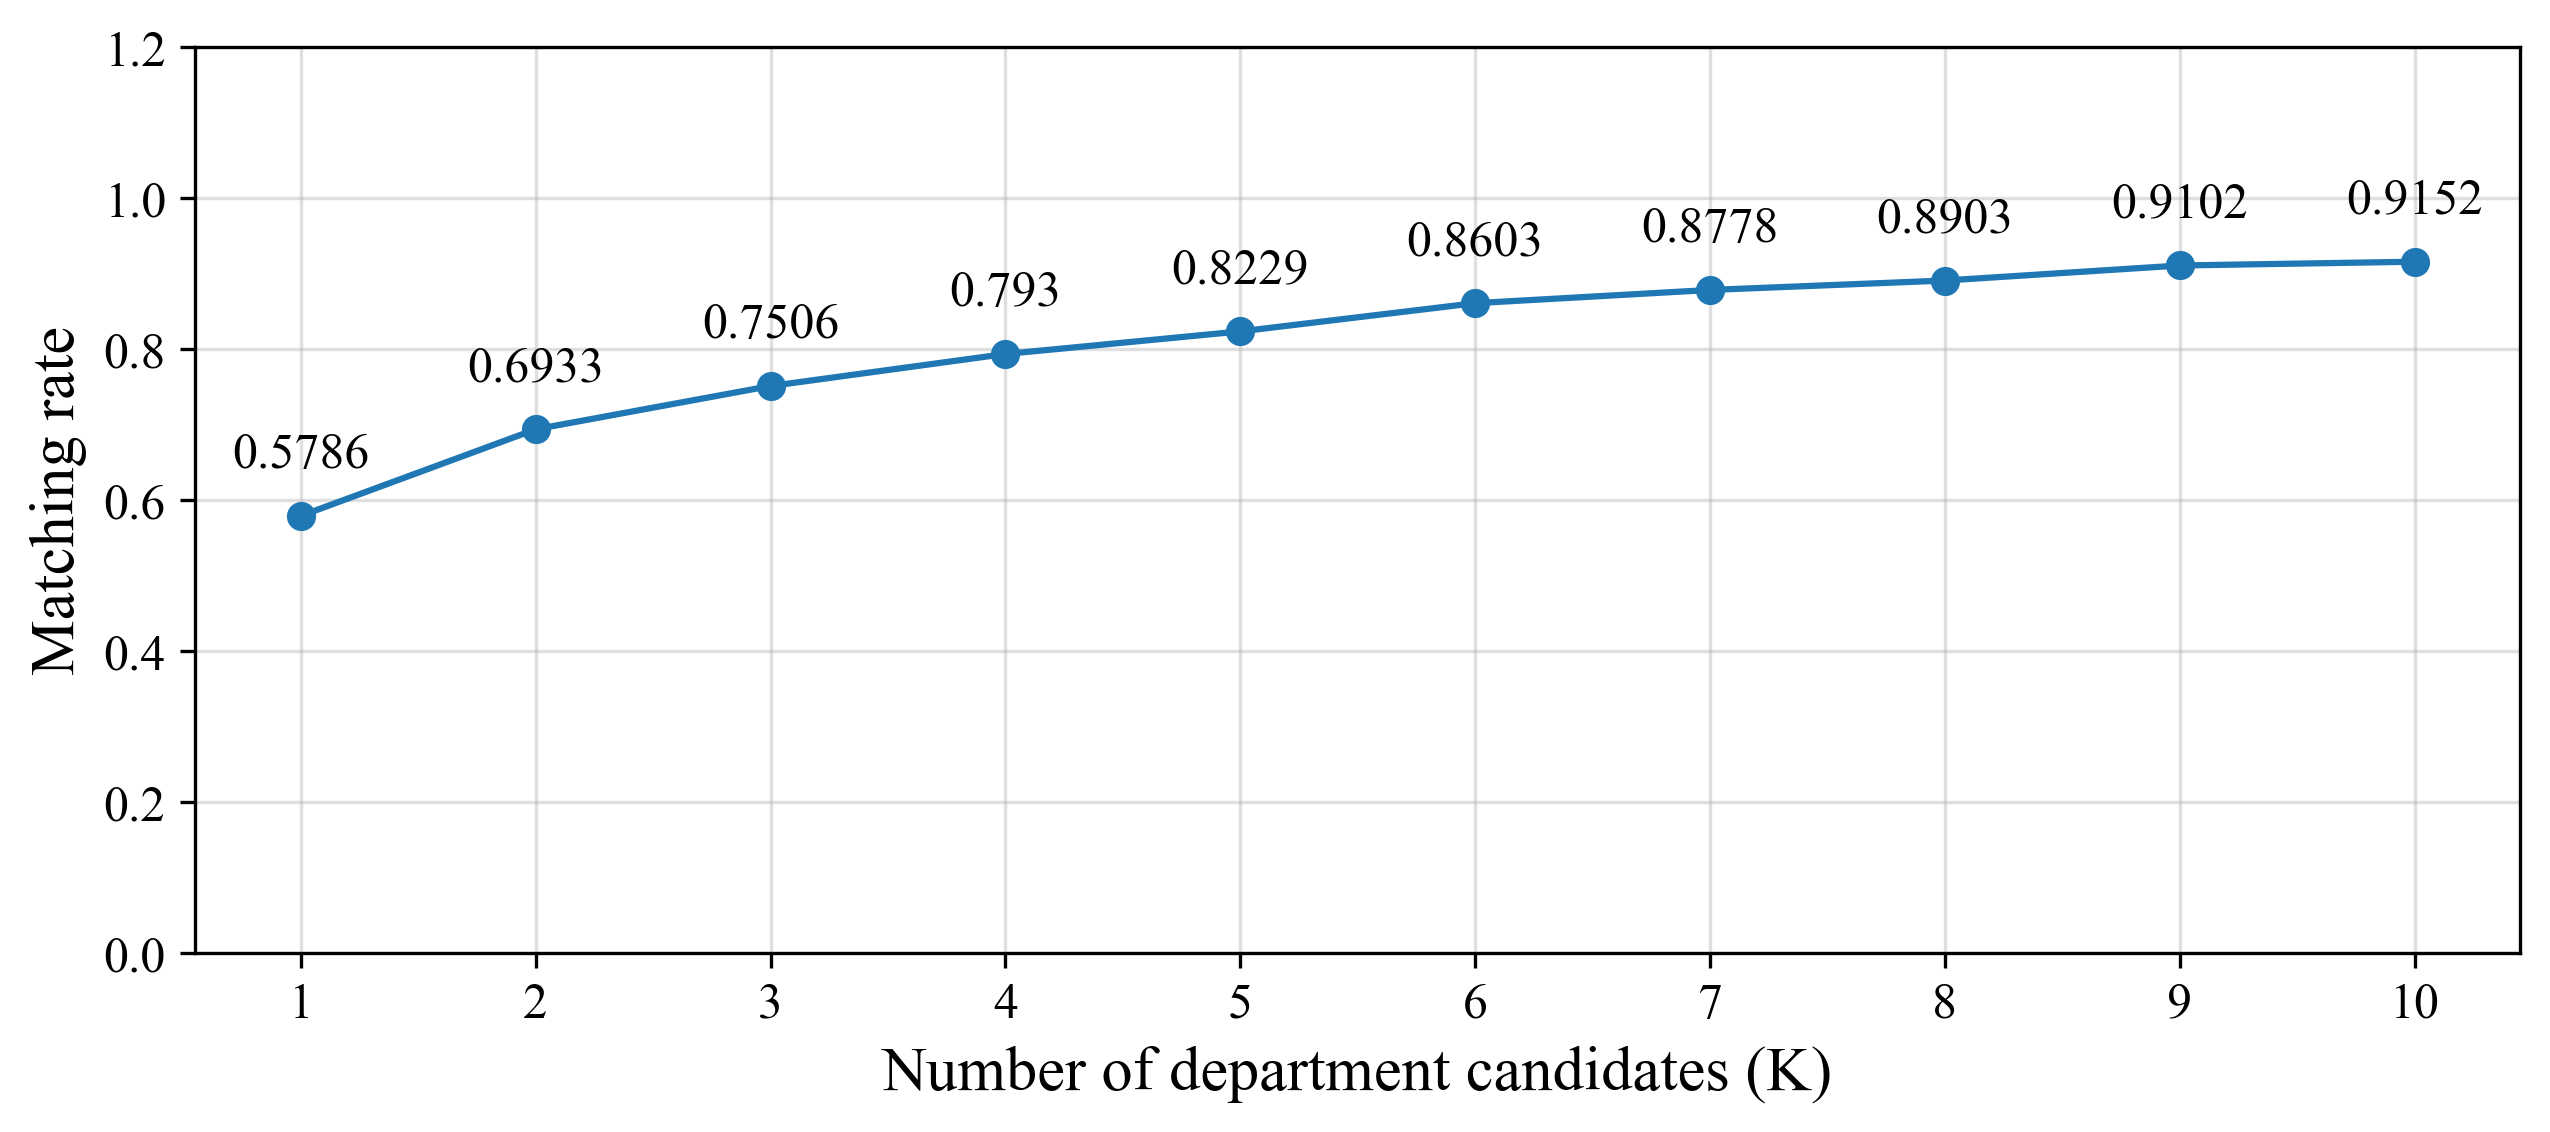

In [546]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1.2])
ax.set_xlabel('Number of inventor candidates (K)', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1.2])
ax2.set_xlabel('Number of department candidates (K)', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [121]:
# writer = pd.ExcelWriter("../results/revision_out.xlsx")
# for df in df_out.values():
#     df.to_excel(writer, sheet_name=df.index.name)
# writer.save()

Sensitivity analysis on vector size

In [503]:
candidates = {
    'n_epochs': [2500],
    'vector_size': [100, 200, 300],
    'window_size': [10],
    'n_neg_samples': [5]
}

In [ ]:
df_out = {}
for n_epochs in candidates['n_epochs']:
    for vector_size in candidates['vector_size']:
        for window_size in candidates['window_size']:
            for n_neg_samples in candidates['n_neg_samples']:
                stime = time.time()
                params['n_epochs'] = n_epochs
                params['vector_size'] = vector_size
                params['window_size'] = window_size
                params['n_neg_samples'] = n_neg_samples
                curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])

                matching_rate = run(params=params)

                df_out[curr_params] = pd.DataFrame.from_dict(matching_rate).rename_axis(curr_params)
                etime = time.time()
                print(f"{np.round(etime-stime, 4)} sec elapsed\n")

[n_epochs: 2500, vector_size: 100, window_size: 10, n_neg_samples: 5]
model training done
1088.7537 sec elapsed

[n_epochs: 2500, vector_size: 200, window_size: 10, n_neg_samples: 5]


In [506]:
df_out

{'n2500v100w10neg5':                   i_n2500v100w10neg5  d_n2500v100w10neg5
 n2500v100w10neg5                                        
 0                             0.4040              0.5810
 1                             0.4688              0.6858
 2                             0.5162              0.7406
 3                             0.5411              0.8005
 4                             0.5686              0.8304
 5                             0.5810              0.8554
 6                             0.5910              0.8703
 7                             0.6035              0.8903
 8                             0.6135              0.8978
 9                             0.6160              0.9027,
 'n2500v200w10neg5':                   i_n2500v200w10neg5  d_n2500v200w10neg5
 n2500v200w10neg5                                        
 0                             0.3815              0.5686
 1                             0.4514              0.7057
 2                             

In [518]:
df_total_i_out.loc['i_n2500v300w10neg5']

n        2500
v         300
w          10
neg         5
0      0.3965
1      0.4589
2      0.5012
3      0.5362
4      0.5586
5      0.5736
6      0.5835
7      0.6035
8      0.6135
9       0.616
Name: i_n2500v300w10neg5, dtype: object

In [507]:
df_total_temp = pd.concat([df for df in df_out.values()], axis=1).T

In [509]:
df_total_temp_i = df_total_temp.loc[pd.Index([x for x in df_total_temp.index if "i" in x])]

In [511]:
df_total_temp_i.to_csv("../results/revision_out_v3(vector_size).csv")

## Previous results

In [493]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# sbert_model = SentenceTransformer('allenai-specter')
# sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [52]:
# vec_inv = calc_vec(ft_model, list_inv)
# vec_tech = calc_vec(ft_model, list_tech)

vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)

# vec_tech = calc_vec(ft_model, list_tech, method='sif_weight', list_total=list_total)
# vec_inv = calc_vec(ft_model, list_inv, method='sif_weight', list_total=list_total)

# vec_tech = calc_vec(sbert_model, list_tech, method='sbert', list_total=list_total)
# vec_inv = calc_vec(sbert_model, list_inv, method='sbert', list_total=list_total)

top_candidates = calc_rank(vec_tech, vec_inv, topk=10)

In [53]:
idx = 14
matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
for i in range(len(top_candidates[index_tech[idx]]['title'])):
    matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
matchmaking_example = matchmaking_example.T

display(matchmaking_example)

,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Transfer of Conversational Language Analysis Technology Know-how for Conversational Interfaces i...,서정연,NAME_256,컴퓨터공학전공,DEPART_60,1.0
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Conversational Language Analysis Technology for Conversational Interfaces in Automotive Environm...,서정연,NAME_256,컴퓨터공학전공,DEPART_60,0.9938
0,Understanding and Application of Conversational Analysis,이요안,NAME_399,영미어문전공,DEPART_48,0.8893
0,Comprehensive Discussion: Conversational Analysis and Meaning of Korean Language,조은경,NAME_546,글로벌한국학전공,DEPART_13,0.7761
0,A Study on Speech Language-Based Technology,구명완,NAME_58,컴퓨터공학전공,DEPART_60,0.7582
0,Roof-Crush Protection Design of Automotive Bodies Using Clustering and Pattern Recognition,이승엽,NAME_393,기계공학전공,DEPART_14,0.7564
0,A Case Study on the Failure of Knowledge Transfer in International Joint Venture Companies: Focu...,안준모,NAME_300,기술경영전문대학원,DEPART_15,0.7468
0,"Manufacturing, Motion Control and Application of Metal Nanostructures Using Interfaces",강태욱,NAME_47,화공생명공학전공,DEPART_62,0.7444


In [61]:
top_candidates[index_tech[idx]]['title'].iloc[0]

'Conversational Language Analysis Technology for Conversational Interfaces in Automotive Environments'

In [108]:
cnt_matched['inventor']

5000000737    1
5000000739    1
5000000740    0
5000000741    1
5000000751    1
             ..
5000002043    0
5000002044    1
5000002045    1
5000002046    1
5000002048    1
Length: 401, dtype: int64

In [114]:
top_candidates[id_target]['inventor']

inv_no
4000008564    박형민
2000029139    소재우
2000032049    정성원
2000030784    서용덕
26329         강석주
26623         김영록
2000025496    낭종호
4000007840    성원진
4000002470    유양모
31416          박석
Name: name, dtype: object

In [116]:
cnt_matched['inventor']

5000000737    1
5000000739    1
5000000740    0
5000000741    1
5000000751    1
             ..
5000002043    0
5000002044    1
5000002045    1
5000002046    1
5000002048    1
Length: 401, dtype: int64

In [117]:
outcomes.loc[id_target]

예외                                            NaN
학년도                                          2020
성과물구분                                           6
성과물구분명                                       기술이전
기준일                           2020-12-21 00:00:00
제목           우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전
상위소속명                                         공학부
소속명                                        전자공학전공
교직원번호                                      101606
성명                                            박형민
관련연구과제                                        NaN
발송여부                                            예
성과물확인                                           예
교원업적                                          아니오
자료제출방법                                        NaN
연동여부(KRI)                                   False
검증여부                                          NaN
전송일시(KRI)                                     NaN
총저자수                                            0
Name: 5000002048, dtype: object

In [40]:
# Matching ratio
matching_rate = {'inventor': [], 'department': []}
for k in range(1,11):
    print("For top",k)
    top_candidates = calc_rank(vec_tech, vec_inv, topk=k)
    eval_matched = {}
    cnt_matched = {}
    cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    for id_target in tqdm(vec_tech.index):
        if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
            cnt_matched['inventor'].loc[id_target] += 1
        if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
            cnt_matched['department'].loc[id_target] += 1
    eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
    eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
    print("Hit ratio (inventor):", eval_matched['inventor'])
    print("Hit ratio (department):", eval_matched['department'])
    print("\n")
    matching_rate['inventor'].append(eval_matched['inventor'])
    matching_rate['department'].append(eval_matched['department'])

For top 1


100%|██████████| 401/401 [00:00<00:00, 2017.46it/s]


Hit ratio (inventor): 0.2045
Hit ratio (department): 0.4239


For top 2


100%|██████████| 401/401 [00:00<00:00, 1963.57it/s]


Hit ratio (inventor): 0.2668
Hit ratio (department): 0.5511


For top 3


100%|██████████| 401/401 [00:00<00:00, 1920.05it/s]


Hit ratio (inventor): 0.3092
Hit ratio (department): 0.6085


For top 4


100%|██████████| 401/401 [00:00<00:00, 1909.53it/s]


Hit ratio (inventor): 0.3466
Hit ratio (department): 0.6484


For top 5


100%|██████████| 401/401 [00:00<00:00, 1906.35it/s]


Hit ratio (inventor): 0.3541
Hit ratio (department): 0.6683


For top 6


100%|██████████| 401/401 [00:00<00:00, 1872.24it/s]


Hit ratio (inventor): 0.3791
Hit ratio (department): 0.6983


For top 7


100%|██████████| 401/401 [00:00<00:00, 1169.25it/s]


Hit ratio (inventor): 0.399
Hit ratio (department): 0.7332


For top 8


100%|██████████| 401/401 [00:00<00:00, 1335.68it/s]


Hit ratio (inventor): 0.419
Hit ratio (department): 0.7481


For top 9


100%|██████████| 401/401 [00:00<00:00, 1883.44it/s]


Hit ratio (inventor): 0.4314
Hit ratio (department): 0.7606


For top 10


100%|██████████| 401/401 [00:00<00:00, 1891.02it/s]

Hit ratio (inventor): 0.4389
Hit ratio (department): 0.7681




/tmp/ipykernel_17174/2674200302.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
/tmp/ipykernel_17174/2674200302.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)


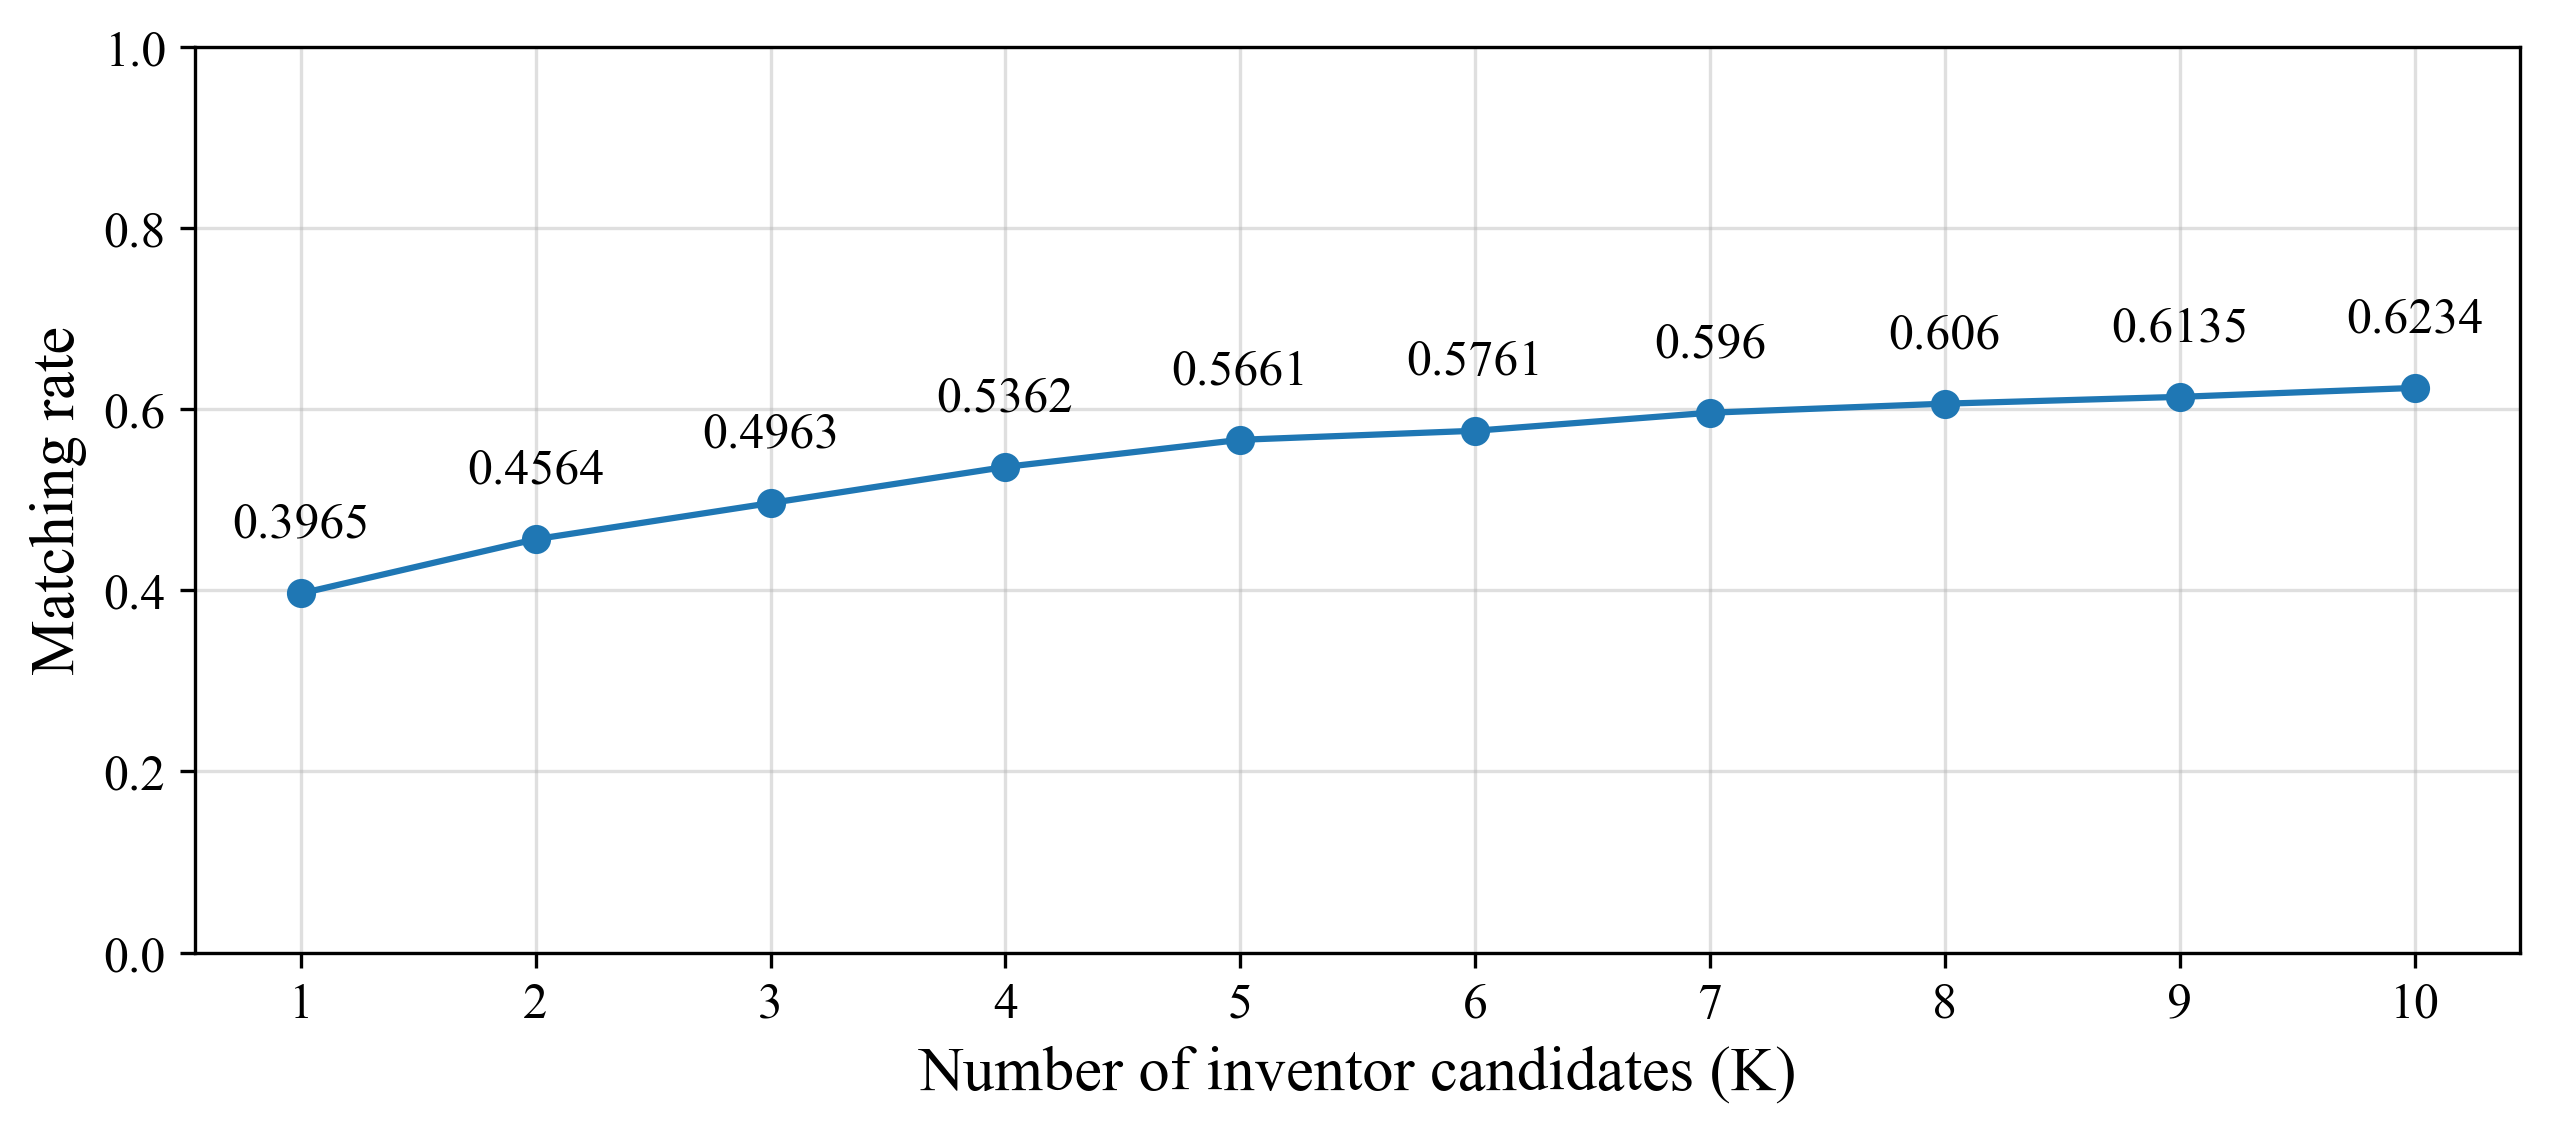

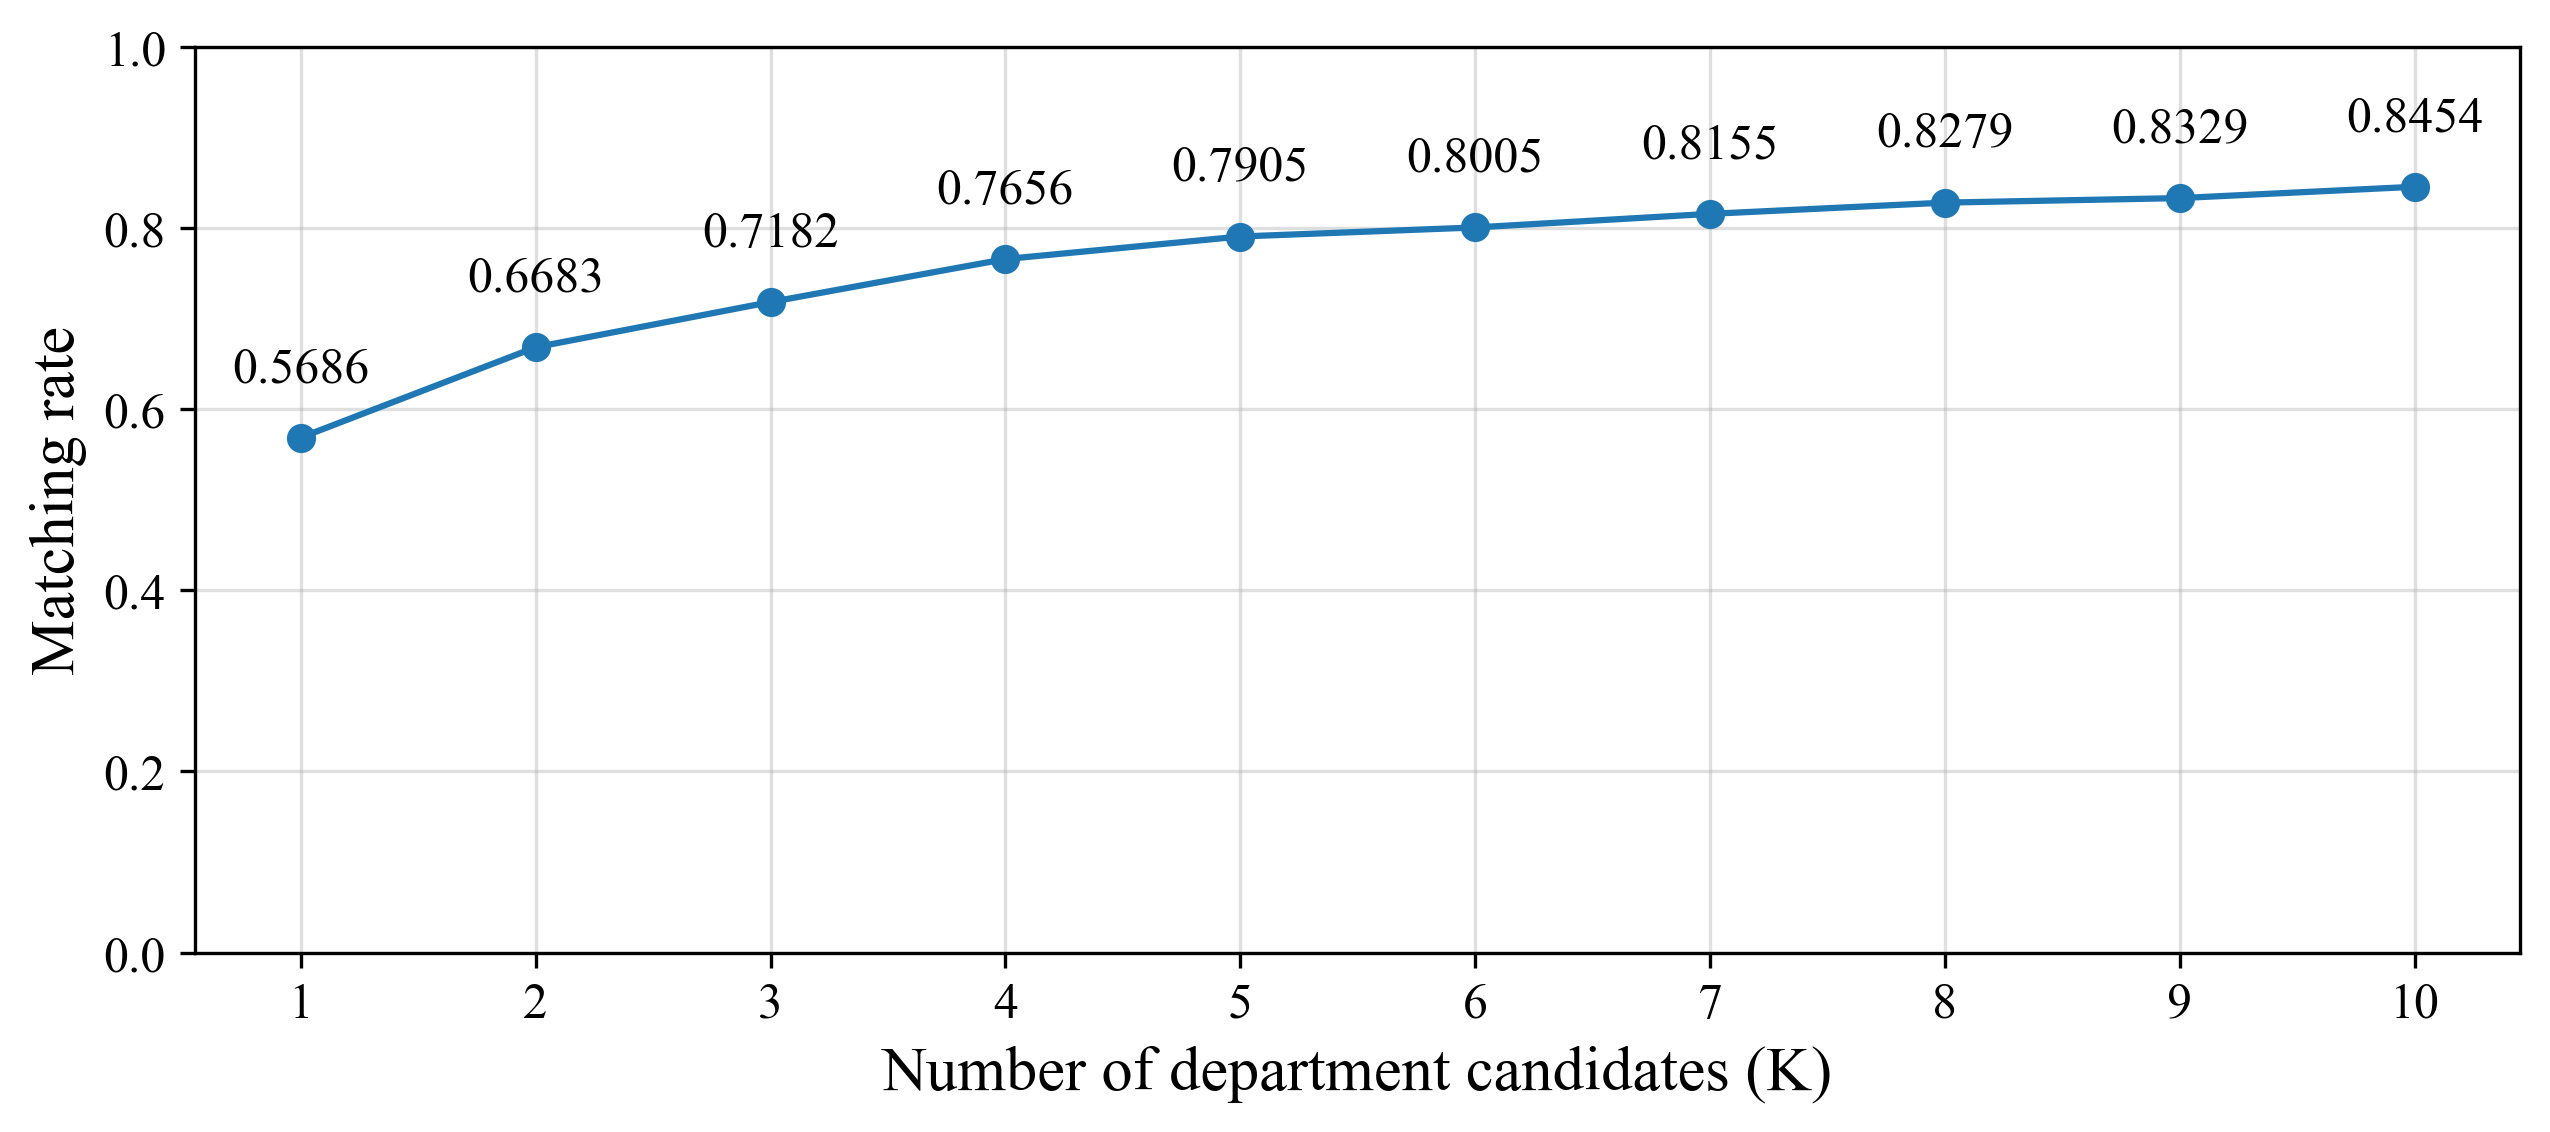

In [546]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1])
ax.set_xlabel('Number of inventor candidates (K)', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1])
ax2.set_xlabel('Number of department candidates (K)', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [ ]:
def get_result(method='avg'):
    print(f"For METHOD {method}")
    
    vec_tech = calc_vec(ft_model, list_tech, method=method, list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method=method, list_total=list_total)
    top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=10)

    idx = 16
    matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
    for i in range(len(top_candidates[index_tech[idx]]['title'])):
        matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
    matchmaking_example = matchmaking_example.T

    display(matchmaking_example)
    
    # Matching ratio
    matching_rate = {'inventor': [], 'department': []}
    for k in range(1,11):
        print("For top",k)
        top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=k)
        eval_matched = {}
        cnt_matched = {}
        cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        for id_target in tqdm(vec_tech.index):
            if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
                cnt_matched['inventor'].loc[id_target] += 1
            if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
                cnt_matched['department'].loc[id_target] += 1
        eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
        eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
        print("Hit ratio (inventor):", eval_matched['inventor'])
        print("Hit ratio (department):", eval_matched['department'])
        print("\n")
        matching_rate['inventor'].append(eval_matched['inventor'])
        matching_rate['department'].append(eval_matched['department'])
        
    # %matplotlib inline
    plt.rcParams['font.family'] = 'Times New Roman'

    fig, ax = plt.subplots(figsize=(10,4), dpi=300)
    ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['inventor']):
        ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of inventor candidates', fontsize=15)
    ax.set_ylabel('Matching rate', fontsize=15)
    ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
    ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Inventor.jpg")

    fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
    ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['department']):
        ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
    ax2.set_ylim([0,1])
    ax2.set_xlabel('Number of departments', fontsize=15)
    ax2.set_ylabel('Matching rate', fontsize=15)
    ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
    ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax2.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Department.jpg")
    print("-"*50)

In [ ]:
methods = ['avg', 'sum', 'sif', 'sif_weight']
for method in methods:
    get_result(method=method)